# Clustering ommatidia by lamina connection counts
- Does clustering resemble retinotopic variability of ommatidia?

In [1]:
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D 
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

import sys
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.vis.hex_lattice import hexplot
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm, shortened_st


In [2]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module

### SAVE FIGS? ###
save_figs = False
if save_figs:
    fig_path = '/mnt/home/nchua/Dropbox/lamina_figures/4-retvar/'

In [3]:
# Load dataframe of om->[connection counts]
tp = '210809'
lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = ommatidia = np.unique(lamina_links['pre_om'])

all_cxvecs = assemble_cxvectors(lamina_links)  # each om has a vector of connection counts

In [4]:
# Connection types with a mean count of less than thresh will not be used for clustering
thresh = 1.0

display(len(all_cxvecs.columns))
for cx, v in all_cxvecs.iteritems():
    if any(v.isna()):
        print(cx)
cxvecs = all_cxvecs.loc[:, all_cxvecs.mean() >= thresh].fillna(0.0)  
#display(len(cxvecs.columns))
cxvecs = cxvecs.rename_axis(index='om')
display(cxvecs.describe())

136

,LMC_2->LMC_1,LMC_2->LMC_2,LMC_2->LMC_3,LMC_2->LMC_4,R_duet->LMC_1,R_duet->LMC_2,R_duet->LMC_3,R_duet->LMC_4,R_duet->R7p,R_duet->centri,...,centri->LMC_2,centri->LMC_3,centri->R7,centri->R7p,centri->R8,centri->R_duet,R_quartet->eLMC_2,R_quartet->eLMC_4,R_duet->eLMC_4,LMC_2->eLMC_4
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,21.931034,5.137931,13.034483,13.827586,35.172414,53.448276,37.344828,13.344828,12.586207,33.379310,...,20.793103,15.586207,7.137931,23.931034,15.655172,22.344828,5.517241,6.517241,6.241379,8.862069
std,4.854534,4.501779,6.790133,9.384900,6.397929,9.919628,7.987829,9.659473,5.348680,10.234444,...,7.943458,6.247955,6.162816,6.278825,5.373718,6.183364,10.520798,9.876454,6.817285,8.153545
min,14.000000,0.000000,0.000000,0.000000,23.000000,22.000000,23.000000,0.000000,5.000000,11.000000,...,7.000000,3.000000,0.000000,13.000000,8.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1.000000,9.000000,7.000000,31.000000,48.000000,32.000000,5.000000,9.000000,28.000000,...,15.000000,10.000000,2.000000,19.000000,12.000000,20.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,4.000000,12.000000,17.000000,35.000000,56.000000,35.000000,15.000000,11.000000,33.000000,...,20.000000,15.000000,5.000000,23.000000,14.000000,23.000000,0.000000,4.000000,5.000000,10.000000
75%,24.000000,8.000000,16.000000,18.000000,39.000000,59.000000,42.000000,21.000000,16.000000,39.000000,...,24.000000,21.000000,13.000000,29.000000,18.000000,27.000000,11.000000,9.000000,11.000000,16.000000
max,33.000000,16.000000,30.000000,33.000000,49.000000,74.000000,58.000000,28.000000,26.000000,52.000000,...,37.000000,28.000000,19.000000,37.000000,28.000000,31.000000,41.000000,49.000000,27.000000,25.000000


In [5]:
dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [o for o in ommatidia if o not in dra_om]
assert(len(dra_om) + len(ndra_om) == 29)
# Colors and marker styles of the different retinotopic groups
dra_c = '#434371'
ndra_c = '#C64191'
dra_m = '^'
ndra_m = 'v'
# Dict with color for each cell subtypes
st_cm = subtype_cm()

In [6]:
# Specifies colors for DRA and non-DRA ommatidia
def om_colors(om_list: List, dra_om: List=dra_om, as_rgb: bool=False, 
              dra_c: str=dra_c, ndra_c: str=ndra_c) -> List:
    
    c_list = []
    for o in om_list:
        if str(o) in dra_om:
            c_list.append(dra_c)
        else:
            c_list.append(ndra_c)
    if as_rgb:
        return [tuple(int(h.lstrip('#')[i:i+2], 16)/255.0 for i in (0, 2, 4)) for h in c_list] 
    else:
        return c_list
    
def om_markers(om_list: List, dra_om: List=dra_om, 
               dra_m: str=dra_m, ndra_m: str=ndra_m) -> List:
    
    m_list = []
    for o in om_list:
        if o in dra_om:
            m_list.append(dra_m)
        else:
            m_list.append(ndra_m)
            
    return m_list

## All connection types including connections to neighboring L4

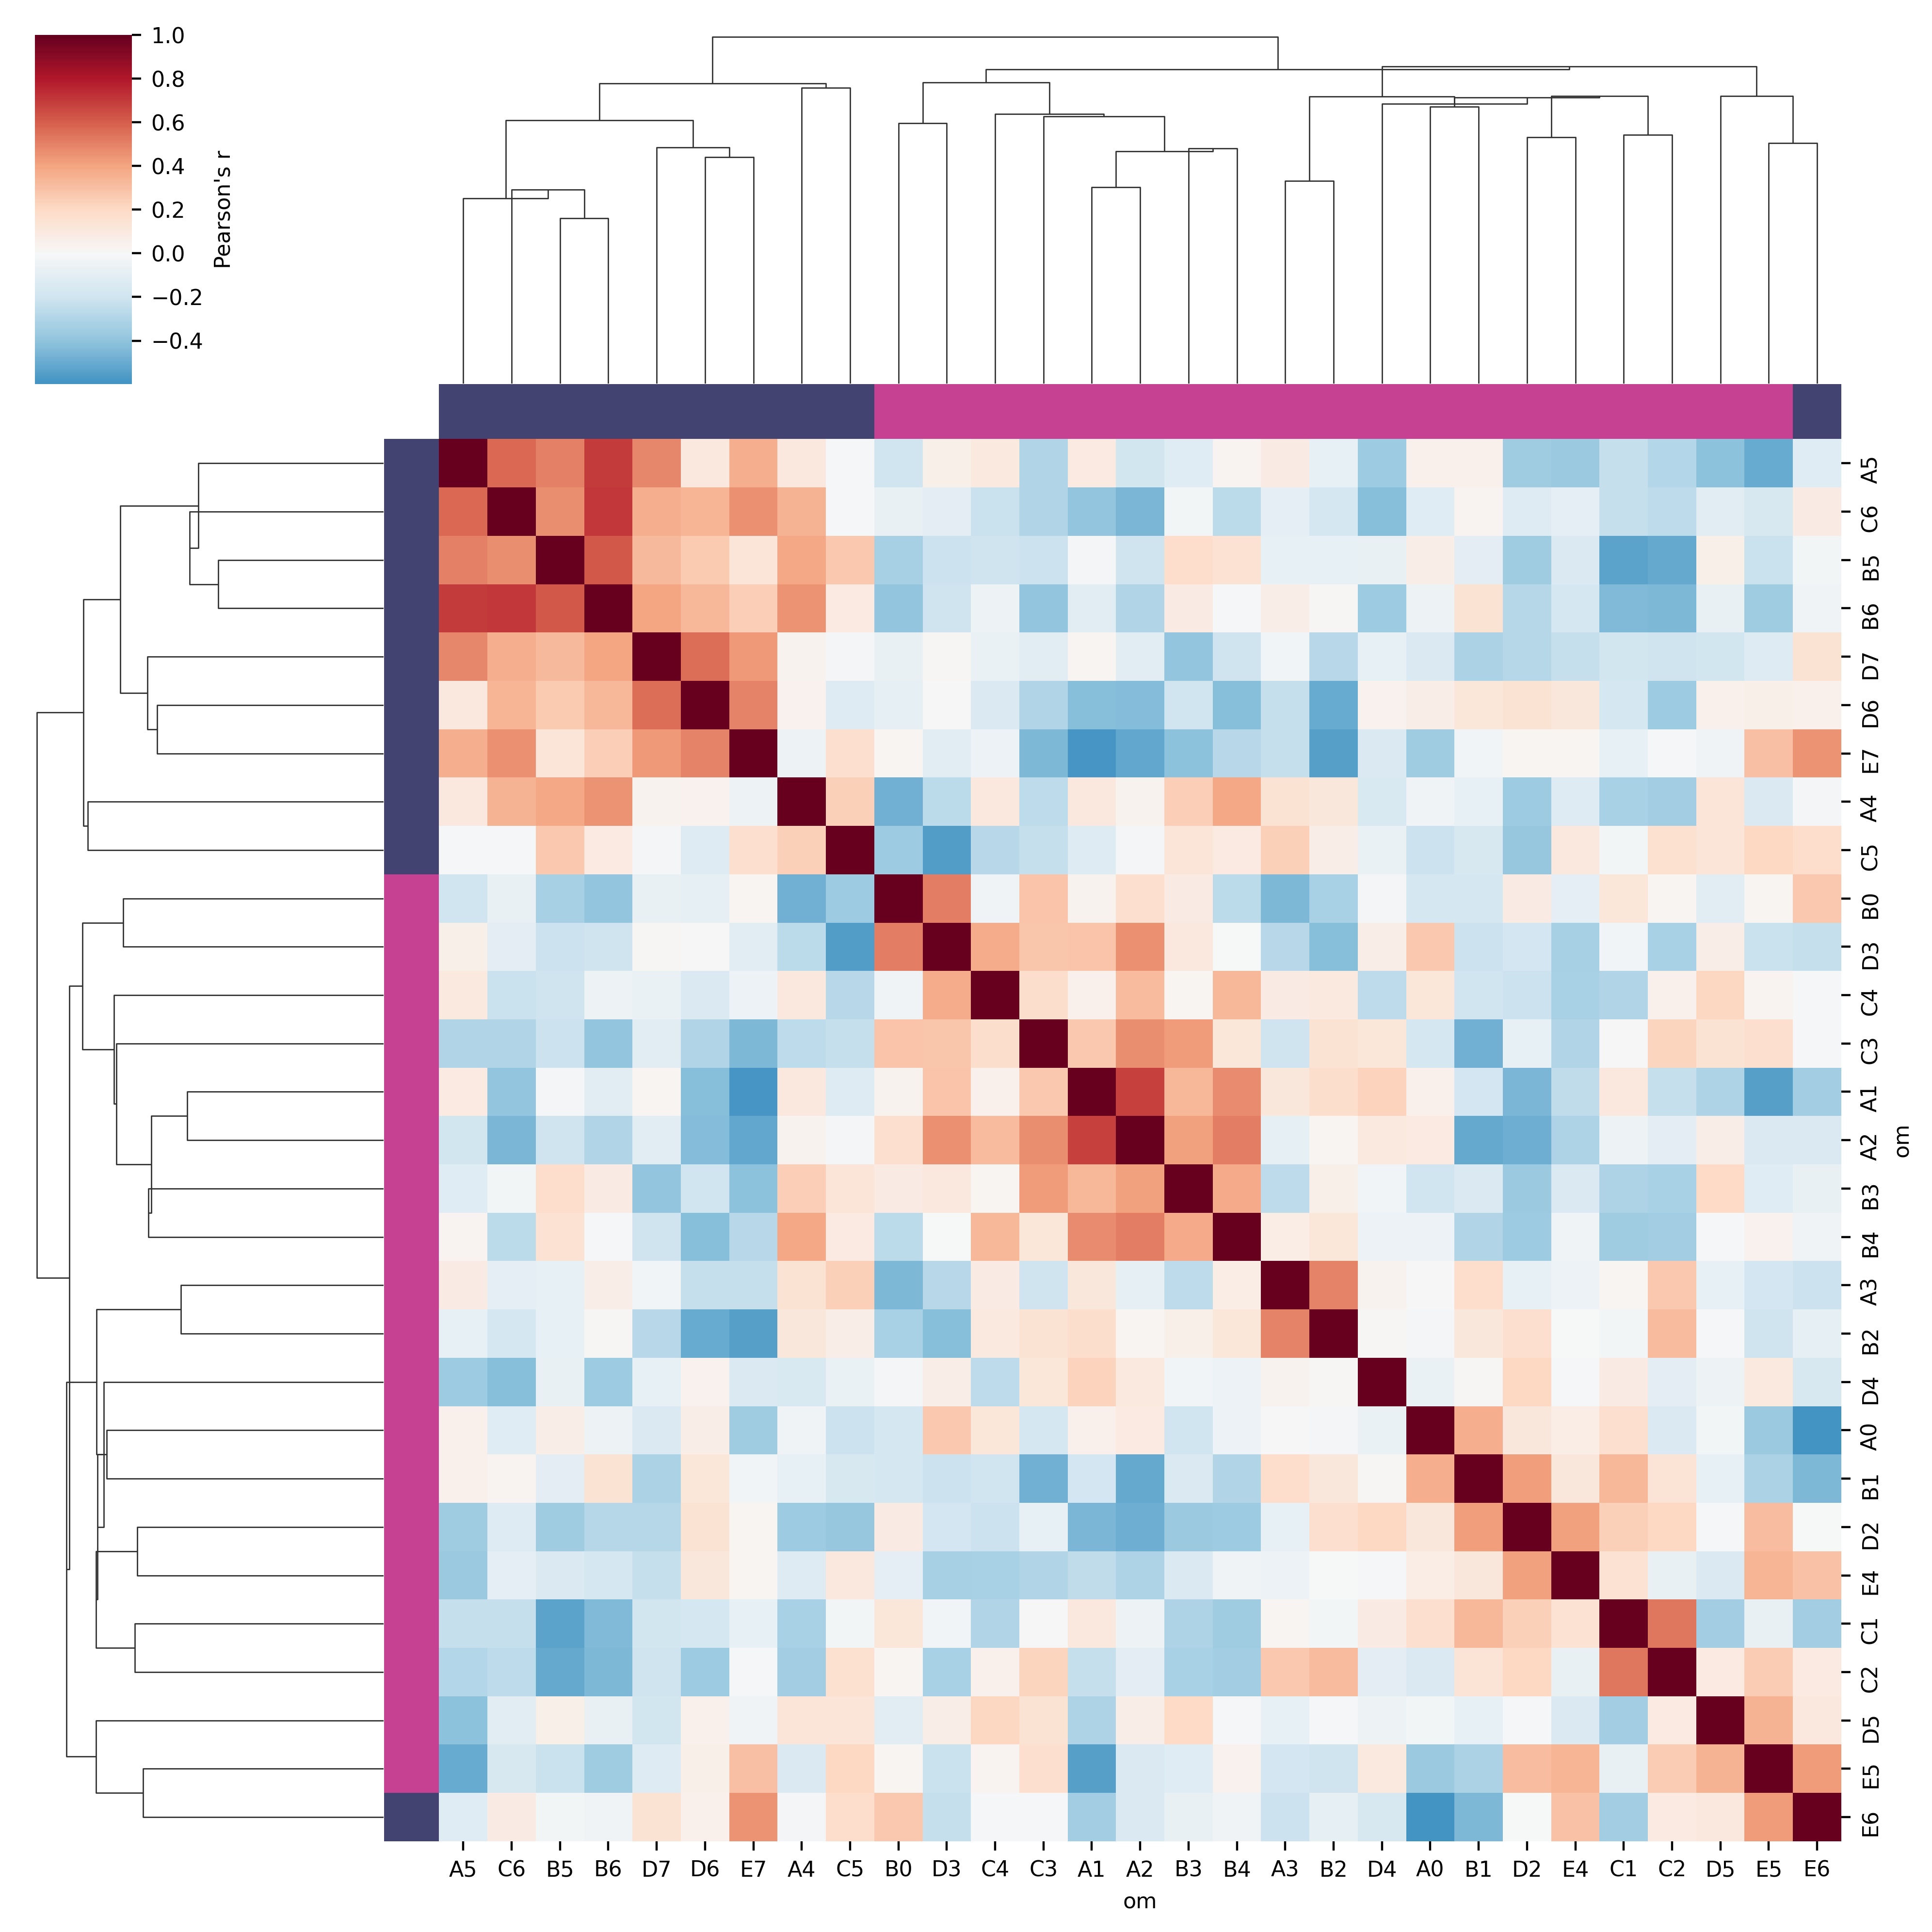

In [7]:
data = cxvecs

z = data.apply(zscore).T
corr_z = z.corr()
#print(corr_z)

x_c = om_colors(corr_z.index)
y_c = om_colors(corr_z.columns)

# clus = sns.clustermap(z, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
#                       col_colors=x_c, 
#                       yticklabels=z.index, 
#                       metric='cosine', method='single')

clus = sns.clustermap(corr_z, metric='euclidean', method='centroid', 
                      cmap='RdBu_r', cbar_kws={'label': "Pearson's r"}, center=0, 
                      row_colors=x_c, col_colors=y_c)
plt.show()

if save_figs:
    clus.savefig(fig_path + f'om-clus_all-cx-mean1.svg')
    clus.savefig(fig_path + f'om-clus_all-cx-mean1.png')

## All connection types EXCLUDING connections to neighboring L4

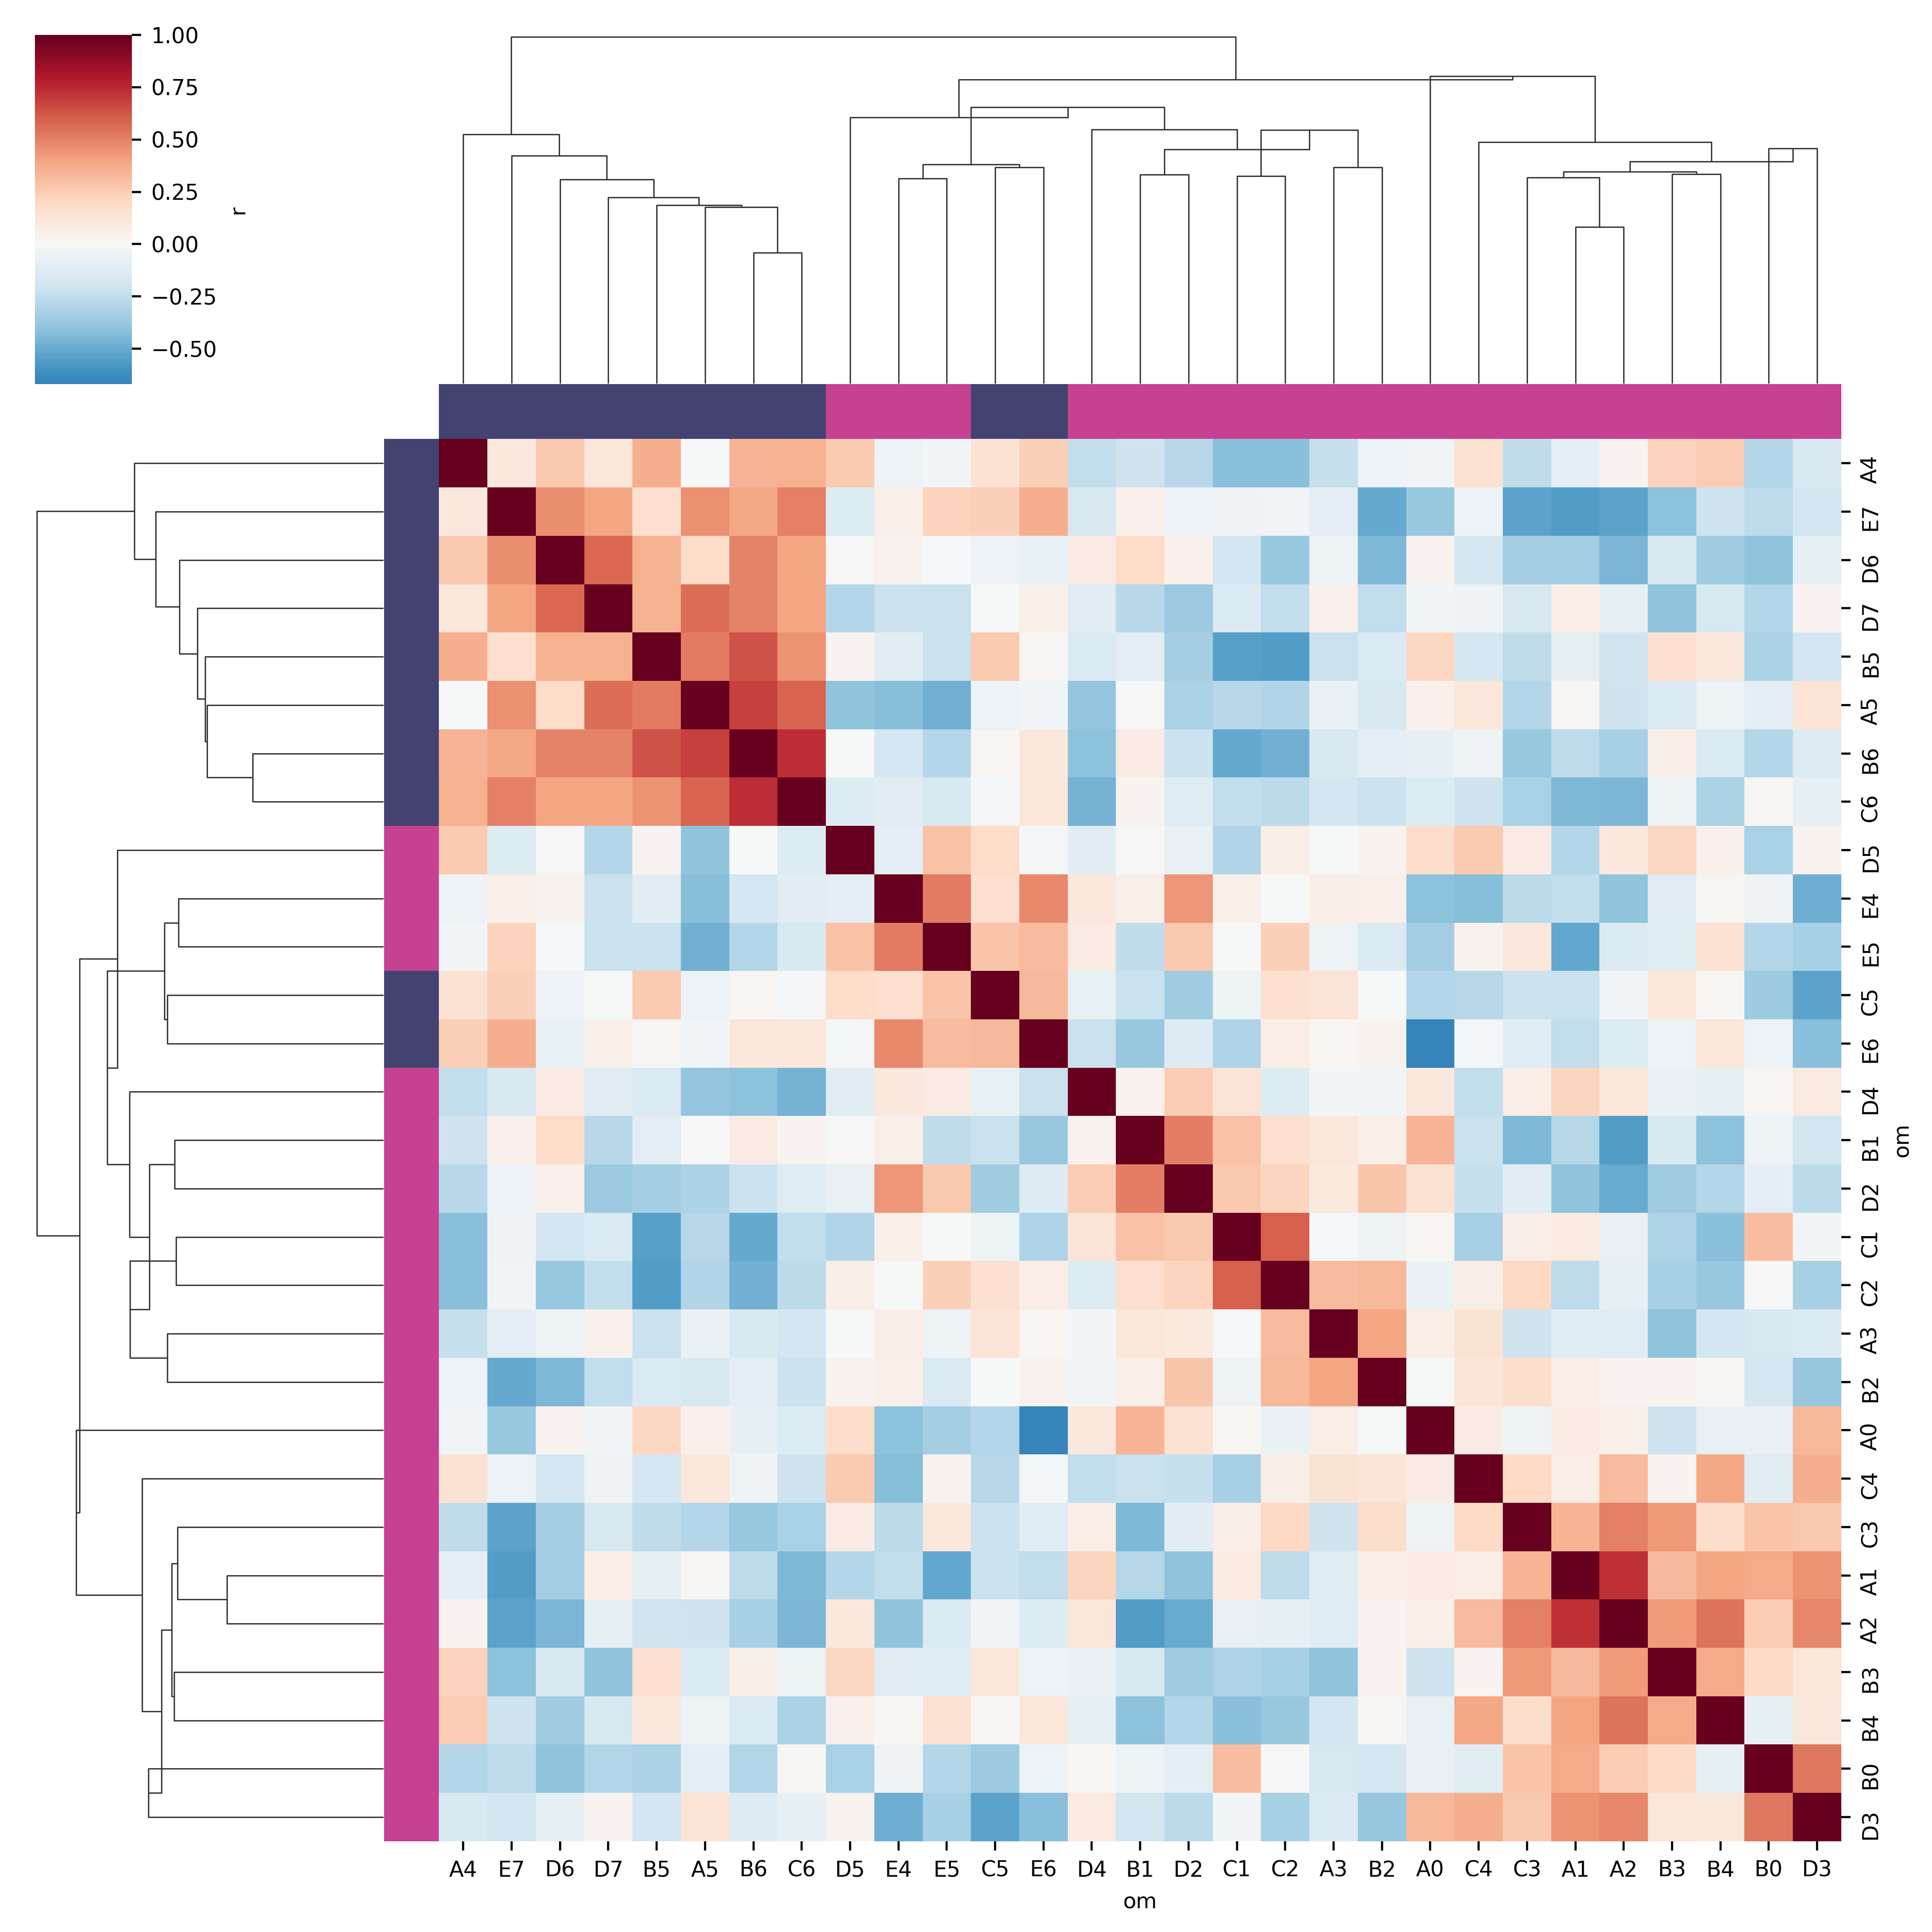

In [8]:
home_cx = [cx for cx in cxvecs.columns if '->e' not in cx]
data = cxvecs.filter(items=home_cx)

z = data.apply(zscore).T
corr_z = z.corr()
#print(corr_z)

x_c = om_colors(corr_z.index)
y_c = om_colors(corr_z.columns)

# clus = sns.clustermap(z, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
#                       col_colors=x_c, 
#                       yticklabels=z.index, 
#                       metric='cosine', method='single')

clus = sns.clustermap(corr_z, metric='euclidean', method='centroid', 
                      cmap='RdBu_r', cbar_kws={'label': 'r'}, center=0, 
                      row_colors=x_c, col_colors=y_c)
plt.show()

if save_figs:
    clus.savefig(fig_path + f'om-clus_all-cx-mean1_exclude-interom.svg')
    clus.savefig(fig_path + f'om-clus_all-cx-mean1_exclude-interom.png')

## Other clustering parameters

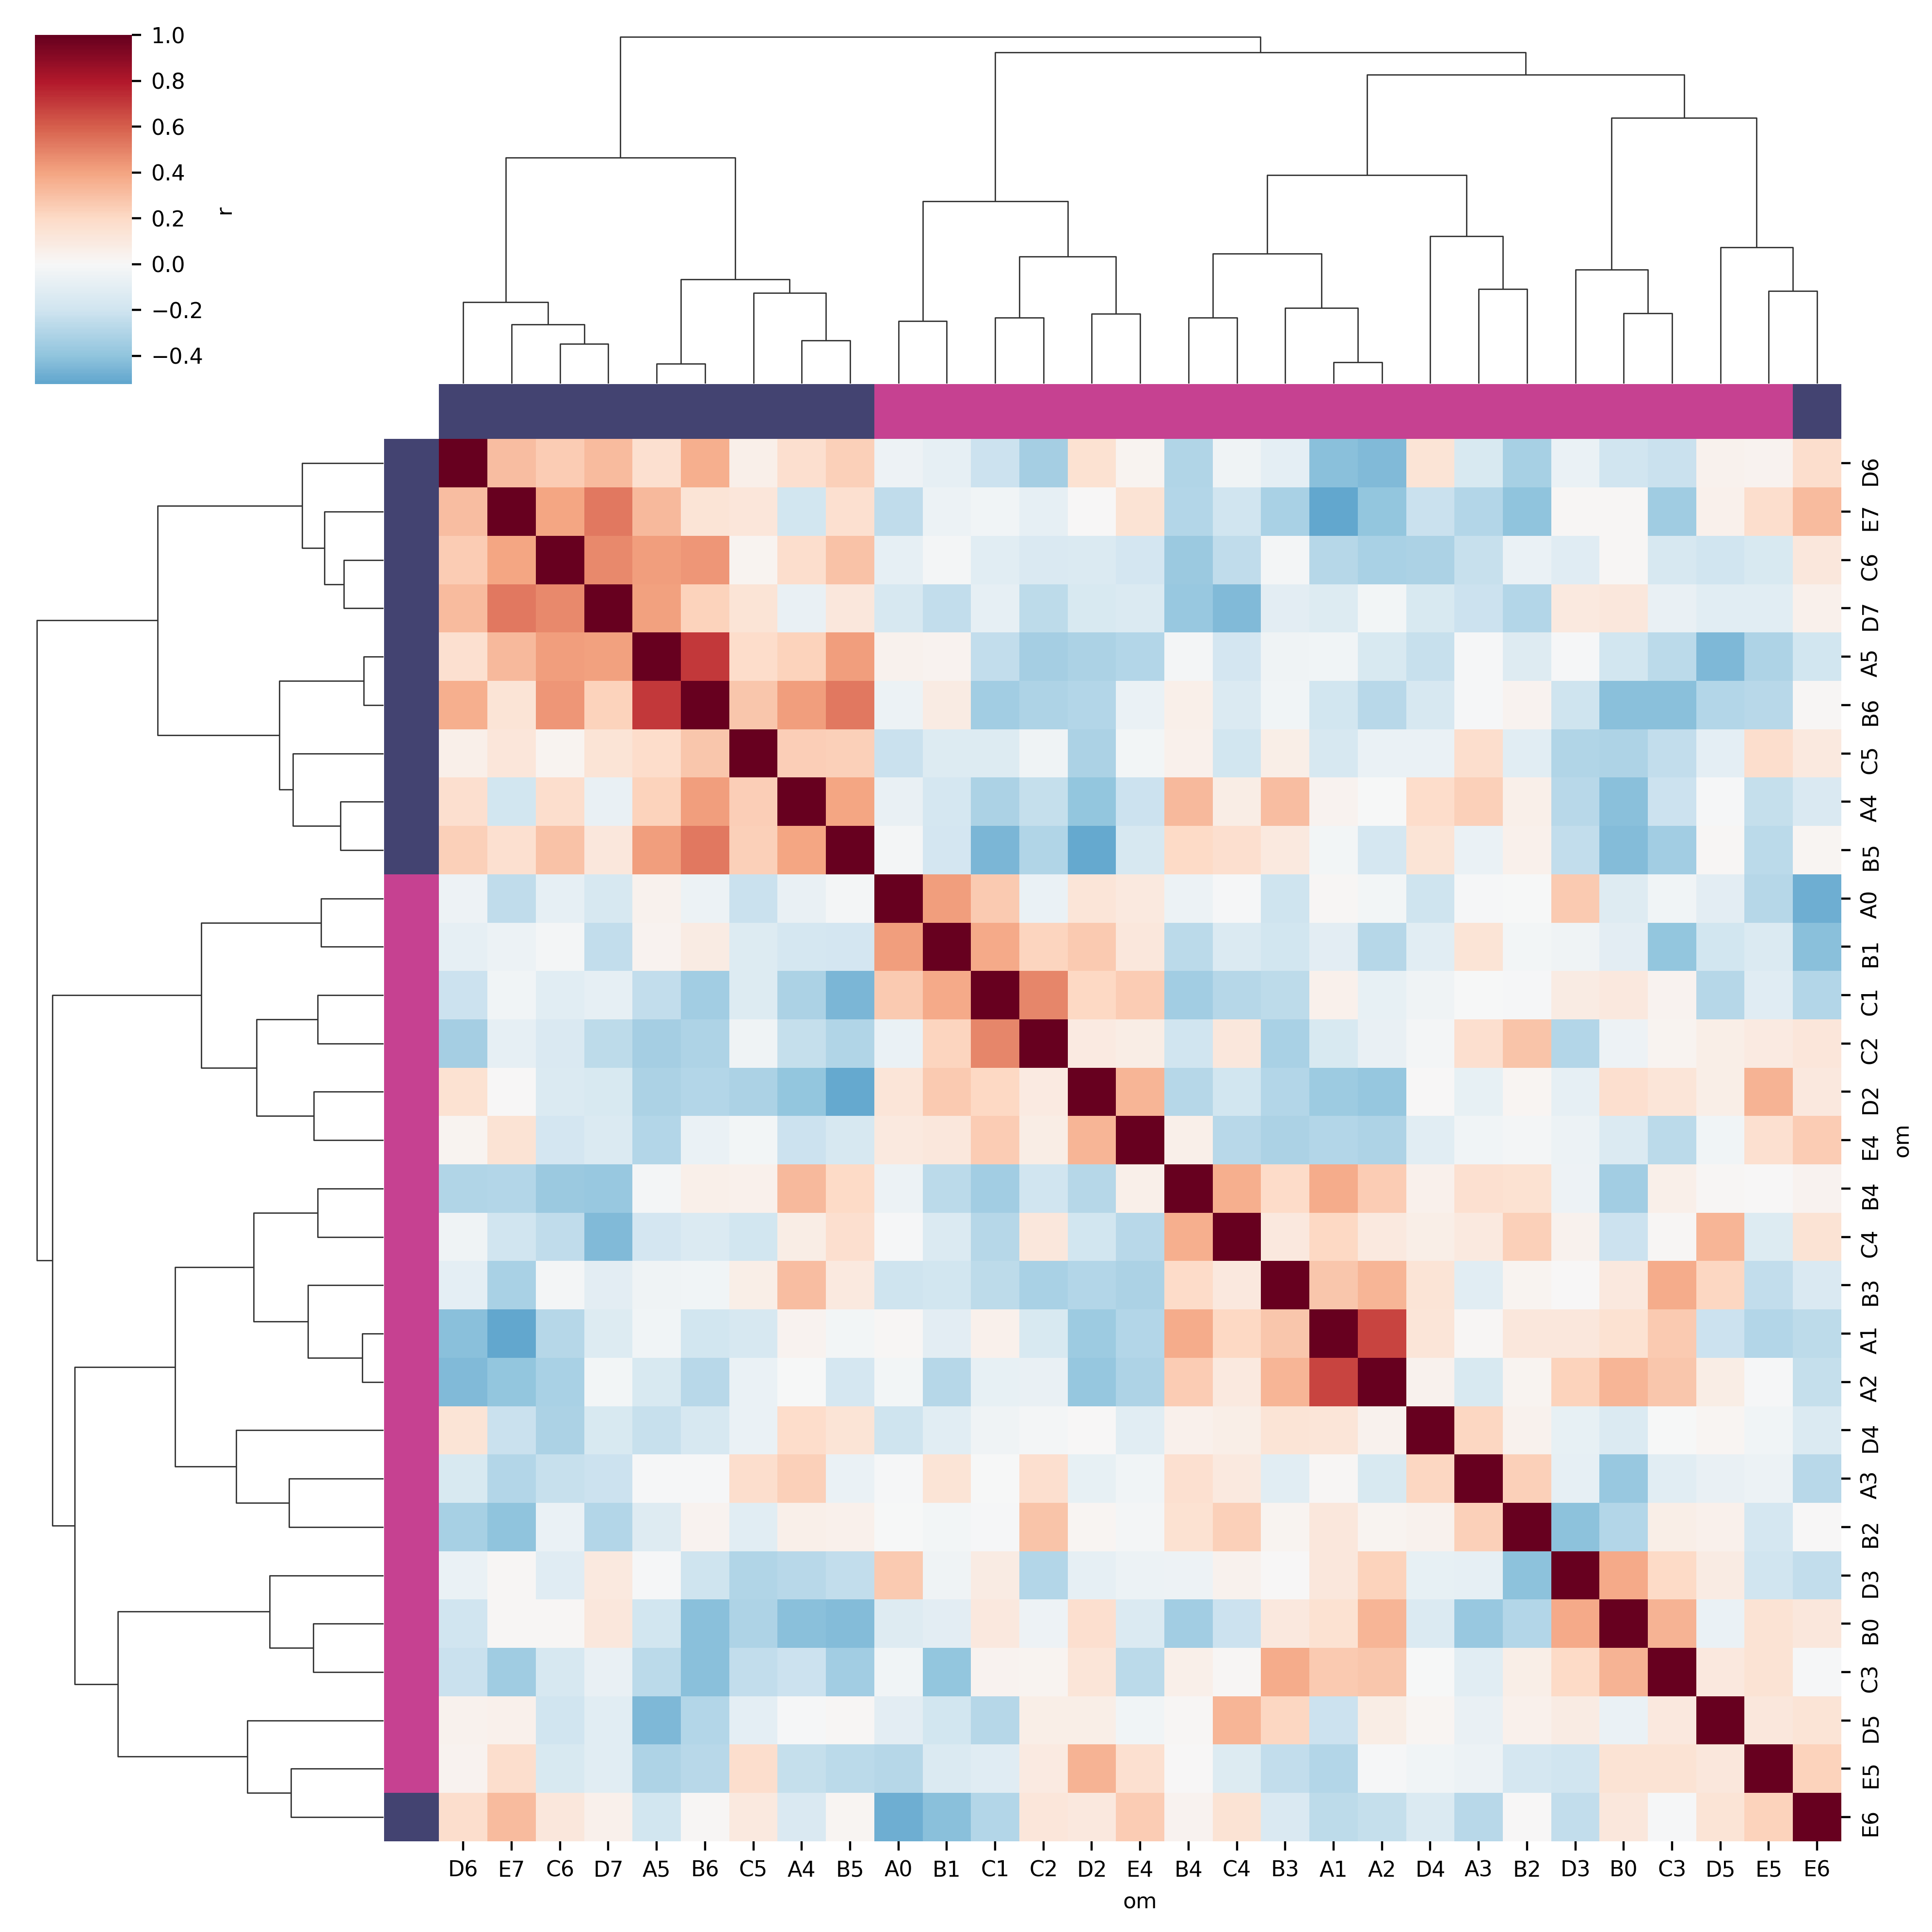

In [11]:
data = cxvecs

z = data.apply(zscore).T
corr_z = z.corr()
#print(corr_z)

x_c = om_colors(corr_z.index)
y_c = om_colors(corr_z.columns)

# clus = sns.clustermap(z, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
#                       col_colors=x_c, 
#                       yticklabels=z.index, 
#                       metric='cosine', method='single')

clus = sns.clustermap(corr_z, metric='cosine', method='complete', 
                      cmap='RdBu_r', cbar_kws={'label': 'r'}, center=0, 
                      row_colors=x_c, col_colors=y_c)
plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.png')

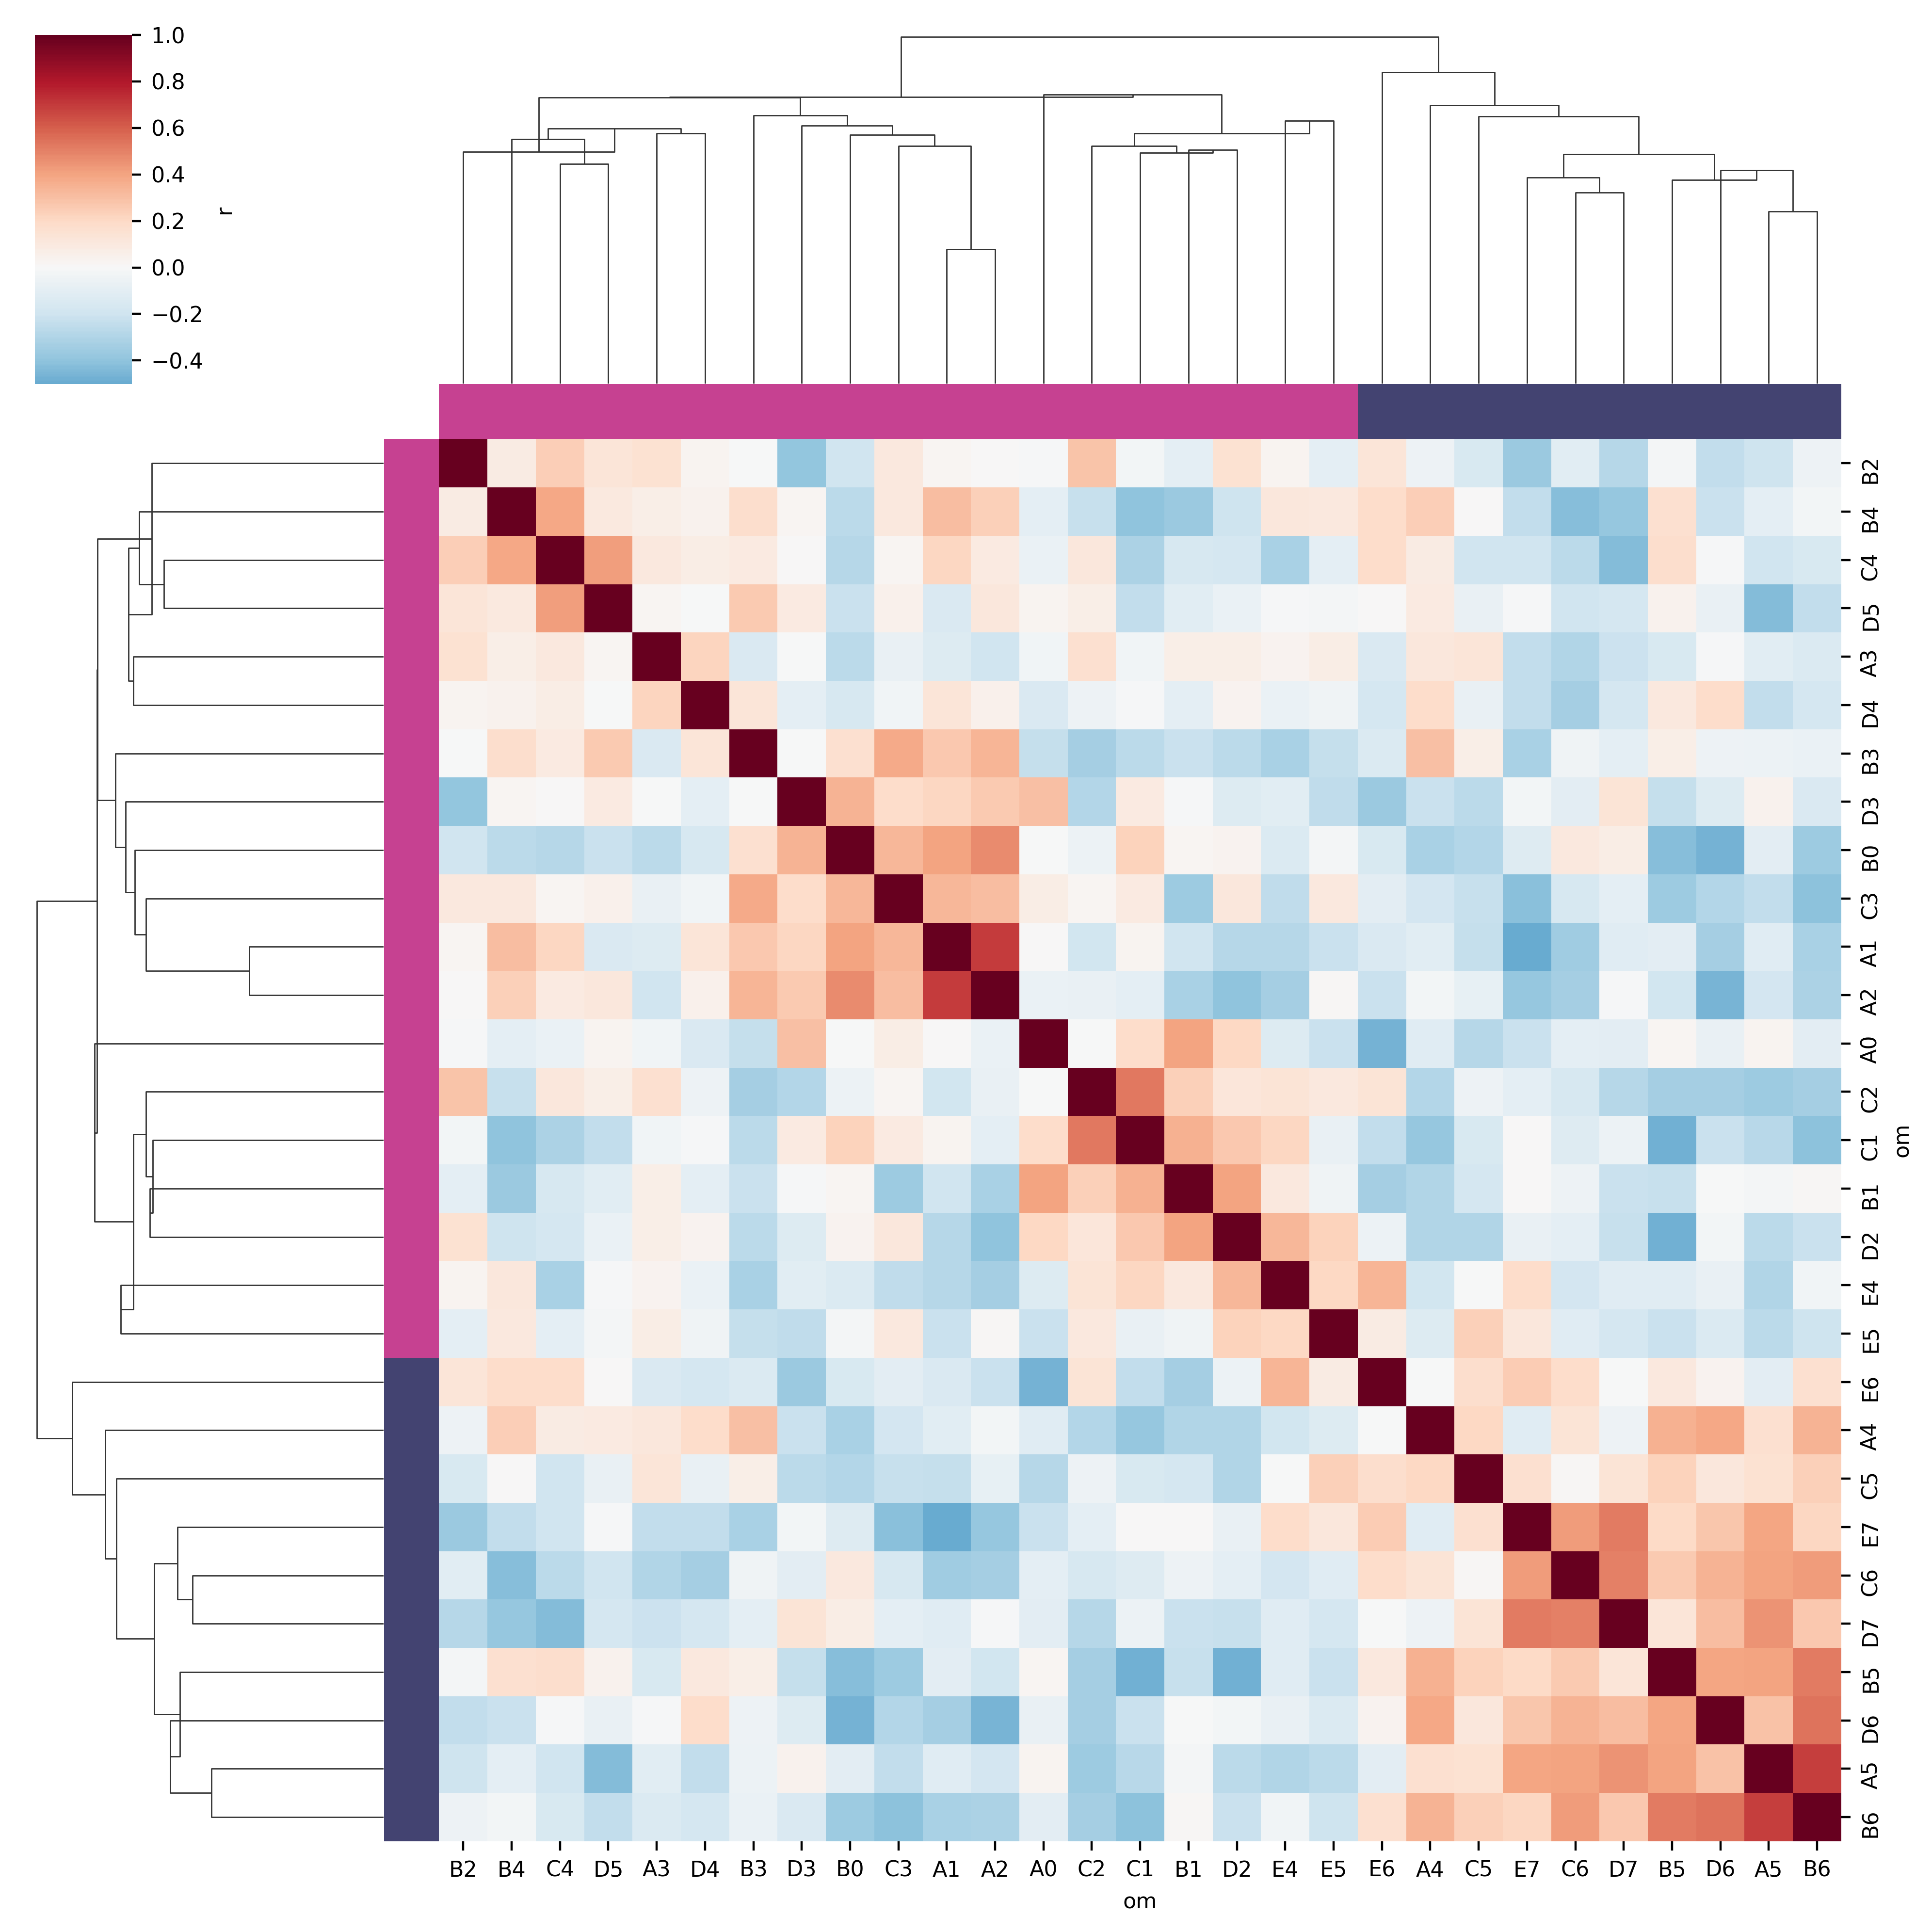

In [9]:
home_cx = [cx for cx in cxvecs.columns if '->e' not in cx]
data = cxvecs.filter(items=home_cx)

z = data.apply(zscore).T
corr_z = z.corr()
#print(corr_z)

x_c = om_colors(corr_z.index)
y_c = om_colors(corr_z.columns)

# clus = sns.clustermap(z, figsize=[6.5,6.5], cmap='RdBu_r', center=0, cbar_kws={'label': 'z-score'}, 
#                       col_colors=x_c, 
#                       yticklabels=z.index, 
#                       metric='cosine', method='single')

clus = sns.clustermap(corr_z, metric='euclidean', method='centroid', 
                      cmap='RdBu_r', cbar_kws={'label': 'r'}, center=0, 
                      row_colors=x_c, col_colors=y_c)
plt.show()

# if save_figs:
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.svg')
#     clus.savefig(f'/mnt/home/nchua/Dropbox/lamina_figures/om_clus_lvfinputs_zscore_thresh{thresh}.png')